In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go  
from sklearn import metrics
from utils import *

init_notebook_mode(connected=True)       

# DCA for SARS-CoV-2

[Direct Coupling Analysis](https://en.wikipedia.org/wiki/Direct_coupling_analysis) mutability scores are provided for all PFAM domains of the SARS-CoV-2 proteome (see Section **Data** at the end of the notebook).
Column in the dataframe: **mutability_score(DCA)**.

We also computed the mutability scores with an independent (non-epistatic) model.
Column: **mutability_score(IND)**.

Both the IND and the DCA model are unsupervised models (no SARS-CoV-2 data in the training set), trained with multiple sequence alignments of homologs sequences from a diverse set of species.

Sites with high mutability scores are expected to be mutable.

The predictions are validated using the genomes of SARS-CoV-2 strains from the (GISAID)[https://www.gisaid.org/] database.

3 different time periods are available for the GISAID data:
1.  January 2020 to July 2020 (Column: **observed_mut_Jul2020**)
2.  January 2020 to Novemeber 2020 (Column: **observed_mut_Nov2020**)
3.  January 2020 to March 2021 (Column: **observed_mut_Mar2021**)


## Receptor Binding Domain

Here we restrict our analysis to the Receptor Binding Domain (```dom = "bCoV_S1_RBD"```) of the SARS-CoV-2 Spike protein (```prot = "Spike" ```).

In [8]:
# Load data (for a specific protein and domain)
prot = "Spike"
dom = "bCoV_S1_RBD"

df = read_dca_iedb_data(path_data = "./data/data_dca_proteome.csv", protein = prot, domain = dom)

#sort by DCA-mutability score to identify putative mutable sites 
df = df.sort_values(by ="mutability_score(DCA)", ascending = False)
df

,protein,domain,position_protein,position_domain,aa_Wuhan-Hu-1,mutability_score(IND),mutability_score(DCA),observed_mut_Mar2021,observed_mut_Nov2020,observed_mut_Jul2020
7618,Spike,bCoV_S1_RBD,519,171.0,H,2.0601,1.2674,13.0,7.0,6.0
7502,Spike,bCoV_S1_RBD,403,55.0,R,-0.4564,0.3610,9.0,7.0,7.0
7589,Spike,bCoV_S1_RBD,490,142.0,F,2.1710,0.2784,52.0,9.0,2.0
7592,Spike,bCoV_S1_RBD,493,145.0,Q,1.0106,0.2627,24.0,8.0,4.0
7471,Spike,bCoV_S1_RBD,372,24.0,A,-0.6028,0.0485,17.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
7490,Spike,bCoV_S1_RBD,391,43.0,C,-5.1836,-8.9496,1.0,0.0,0.0
7522,Spike,bCoV_S1_RBD,423,75.0,Y,-6.6090,-8.9532,0.0,0.0,0.0
7531,Spike,bCoV_S1_RBD,432,84.0,C,-5.6314,-9.0326,1.0,1.0,1.0
7521,Spike,bCoV_S1_RBD,422,74.0,N,-5.7790,-9.1096,0.0,0.0,0.0


## 1. Predicting mutable sites

In Fig. 2 of the paper we apply the DCA and IND model to identify mutations already present in circulating strains.

We consider as:
- **mutable** (1):  a site with **N_mut or more** observed mutations in GISAID strains
- **constrained** (0): a site with **less than N_mut**  observed mutations in GISAID strains

Here we fix N_mut=4 and include GIDAS data from January 2020 to March 2021.


******************************************************
   GISAID data from Jan 2020 to observed_mut_Mar2021
******************************************************
39 sites are constrained (tp = 0)
     constrained if < 4 mutations in GISAID
139 sites are mutable (tp = 1)
     mutable if >= 4 mutations in GISAID


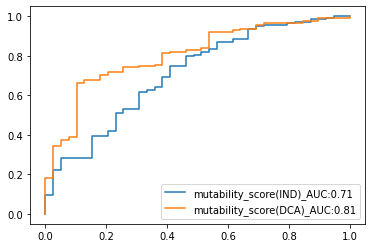

In [3]:
## PPV DCA vs. IND model, FIG.2

# define constrained and mutable sites
N_mut = 4
constrained = range(0,N_mut)
mutable = range(N_mut,1000000) 

# GISAID data 
GISAID = 'observed_mut_Mar2021'

list_score = ['mutability_score(IND)', 'mutability_score(DCA)']
plot_ppv(constrained, mutable, GISAID, list_score, df)


### print some info
num_contrained = np.sum(df[GISAID].isin(constrained))
num_mutable = np.sum(df[GISAID].isin(mutable))

print("******************************************************")
print("   GISAID data from Jan 2020 to {0}".format(GISAID))
print("******************************************************")
print("{0} sites are constrained (tp = 0)".format(num_contrained))
print('     constrained if < '+str(N_mut) + ' mutations in GISAID')
print("{0} sites are mutable (tp = 1)".format(num_mutable))
print('     mutable if >= '+str(N_mut) + ' mutations in GISAID')

### Mutations are accumulating

Here we access the predictive power of the DCA mutability scores considering the 3 different time periods that are available for the GISAID data.

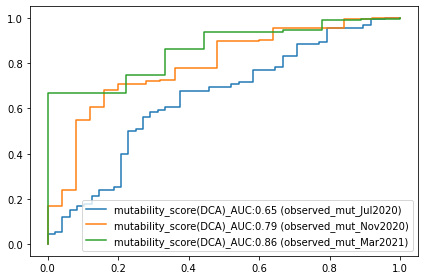

In [4]:
## PPV DCA, GISAID at different time,  FIG.2

# define constrained and mutable sites
N_mut = 1
constrained = range(0,N_mut)
mutable = range(N_mut,1000000) #1000000: a random big number
list_score = ['mutability_score(DCA)']
              
observed_mutability = 'observed_mut_Jul2020'
plot_ppv(constrained, mutable, observed_mutability, list_score, df, add_obs_mut = True)
observed_mutability = 'observed_mut_Nov2020'
plot_ppv(constrained, mutable, observed_mutability, list_score, df, add_obs_mut = True)
observed_mutability = 'observed_mut_Mar2021'
plot_ppv(constrained, mutable, observed_mutability, list_score, df, add_obs_mut = True)
plt.tight_layout()

## 2. Predicting immunologically relevant mutable sites

Nonsynonymous mutations may modify regions of the SARS-CoV-2 genome targeted by B or T cells (known as B/T cell epitopes). 

The [IEDB](https://www.iedb.org/) collects experimentally validated B and T cell epitopes.
Each SARS-CoV-2 sites is associated with the corresponding epitope response frequency (RF), defined as the number of positively responded subjects, averaged over all epitopes mapped to that position. For more details see https://help.iedb.org/hc/en-us/articles/114094147751.

Amino acid substitution at high-RF sites have a higher risk of inducing immune escape as many positively responding epitopes are modified. 

### DCA and IEDB 
Here we plot the DCA mutability score vs. the IEDB response frequency for each site of the RDB domain.

The interesting region is the **upper right corner** containing sites which are expected to be mutable (high DCA score) and that can induce immune escape (high RF).
 
Strains classified as Variants of Concern (VOC) or Variants of Interest (VOI) in the [20th April 2021 WHO report](https://www.who.int/publications/m/item/covid-19-weekly-epidemiological-update) have mutations in  the 417, 452, 477, 483, 484 and 501 positions of the RBD domain (red points in the plot).

In [5]:
# DCA vs. epitope
prot = "Spike"
dom = "bCoV_S1_RBD"
score = 'mutability_score(DCA)'

#positions mutated in VOI/VOC
list_pos_mutated_VOI_VOC = [417, 452, 477, 483, 484,  501] #red points

df = read_dca_iedb_data(path_data = "./data/data_dca_iedb_RDB_domain.csv", protein = prot, domain = dom)

plot_dca_IEDB(df, score, list_pos = list_pos_mutated_VOI_VOC)

0

In [10]:
#Considering only B(T) cell epitopes

prot = "Spike"
dom = "bCoV_S1_RBD"
score = 'mutability_score(DCA)'

#positions mutated in VOI/VOC
list_pos_mutated_VOI_VOC = [417, 452, 477, 483, 484,  501] #red points
df = read_dca_iedb_data(path_data = "./data/data_dca_iedb_RDB_domain_BTcell.csv", protein = prot, domain = dom)

## only B cell epitopes
BT_cell = "B_cell"
print('***** {0} epitopes *****'.format(BT_cell))
plot_dca_IEDB_BTcell(df, score, list_pos = list_pos_mutated_VOI_VOC, cell_type = BT_cell)

## only T cell epitopes
BT_cell = "T_cell"
print('***** {0} epitopes *****'.format(BT_cell))
plot_dca_IEDB_BTcell(df, score, list_pos = list_pos_mutated_VOI_VOC, cell_type = BT_cell)

***** B_cell epitopes *****


***** T_cell epitopes *****


0

### GISAID and IEDB 
Same analysis, but using GISAD observed mutations instead of the DCA mutability score

In [9]:
# observed vs. epitope
prot = "Spike"
dom = "bCoV_S1_RBD"
df = read_dca_iedb_data(path_data = "./data/data_dca_iedb_RDB_domain.csv", protein = prot, domain = dom)

#positions mutated in VOCs or VOIs
list_pos_mutated_VOI_VOC = [417, 452, 477, 483, 484, 501]

score = 'observed_mut_Jul2020'
plot_dca_IEDB(df, score, list_pos = list_pos_mutated_VOI_VOC)
score = 'observed_mut_Nov2020'
plot_dca_IEDB(df, score, list_pos = list_pos_mutated_VOI_VOC)
score = 'observed_mut_Mar2021'
plot_dca_IEDB(df, score, list_pos = list_pos_mutated_VOI_VOC)

0

## 3. Data
DCA predictions are available for the following proteins and protein domains: 
- Spike (also IEDB epitope data)
    - bCoV_S1_N 
    - bCoV_S1_RBD  
    - CoV_S1_C 
    - CoV_S2 
    - CoV_S2_C
- Envelope 
    - CoV_E
- Membrane 
    - CoV_M
- Nucleocapsid 
    - CoV_nucleocap
- ORF10
- ORF1a 
    - bCoV_NAR 
    - bCoV_NSP1 
    - bCoV_NSP3_N 
    - bCoV_SUD_C 
    - bCoV_SUD_M 
    - CoV_NSP10 
    - CoV_NSP2_C 
    - CoV_NSP2_N 
    - CoV_NSP3_C 
    - CoV_NSP4_C 
    - CoV_NSP4_N 
    - CoV_NSP6 
    - CoV_NSP7 
    - CoV_NSP8 
    - CoV_NSP9 
    - CoV_peptidase 
    - Macro Peptidase_C30
- ORF1b 
    - AAA_11 
    - AAA_12 
    - AAA_30 
    - CoV_Methyltr_1 
    - CoV_Methyltr_2 
    - CoV_NSP15_C 
    - CoV_NSP15_M 
    - CoV_NSP15_N 
    - CoV_RPol_N 
    - RdRP_1 
    - UvrD_C_2 
    - Viral_helicase1
- ORF3a 
    - bCoV_viroporin
- ORF6 
    - bCoV_NS6
- ORF7a 
    - bCoV_NS7A
- ORF7b 
    - bCoV_NS7B
- ORF8 
    - bCoV_NS8
